In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

# Understanding recurrent neural networks

This notebook contains the code samples found in Chapter 6, Section 2 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

---

[...]


## numpy 实现RNN

In [0]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64

In [4]:
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
inputs.shape

(100, 32)

In [0]:
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

In [6]:
final_output_sequence.shape

(100, 64)


## Keras 中的循环层

The process we just naively implemented in Numpy corresponds to an actual Keras layer: the `SimpleRNN` layer:


In [0]:
from keras.layers import SimpleRNN

二者有一点小小的区别： SimpleRNN 层能够像其他 Keras 层一样处理序列批量，而不是
像 Numpy 示例那样只能处理单个序列。因此，它接收形状为 (batch_size, timesteps,
input_features) 的输入，而不是 (timesteps, input_features)。

与 Keras 中的所有循环层一样， SimpleRNN 可以在两种不同的模式下运行：一种是返回每
个时间步连续输出的完整序列，即形状为 (batch_size, timesteps, output_features)
的三维张量；另一种是只返回每个输入序列的最终输出，即形状为 (batch_size, output_
features) 的二维张量。这两种模式由 return_sequences 这个构造函数参数来控制。我们
来看一个使用 SimpleRNN 的例子，它只返回最后一个时间步的输出。

In [7]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


### 输出全部时间的y

In [8]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()
# 2080=32*（32+32）+32

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


为了提高网络的表示能力，将多个循环层逐个堆叠有时也是很有用的。在这种情况下，你
需要让所有中间层都返回完整的输出序列。

In [9]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # This last layer only returns the last outputs.
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


## 例子-评论分类

接下来，我们将这个模型应用于 IMDB 电影评论分类问题。首先，对数据进行预处理。

In [10]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # 作为特征的单词个数
maxlen = 500  # 在这么多单词之后截断文本（这些单词都属于前 max_features 个最常见的单词）
batch_size = 32

print('Loading data...')
# 原本的输入中每一个文本的长度都不相同
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

Loading data...
17465344/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences


In [11]:
len(input_train[0])

218

In [12]:
len(input_train[1])

189

In [13]:
print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
# 大于此长度的序列将被截短，小于此长度的序列将在后部填0.
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


我们用一个 Embedding 层和一个 SimpleRNN 层来训练一个简单的循环网络。

In [14]:
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN


model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________


In [15]:
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 19s 969us/step - loss: 0.5847 - acc: 0.6810 - val_loss: 0.5792 - val_acc: 0.6808
Epoch 2/20
20000/20000 [==============================] - 18s 911us/step - loss: 0.3606 - acc: 0.8515 - val_loss: 0.3594 - val_acc: 0.8508
Epoch 3/20
20000/20000 [==============================] - 18s 903us/step - loss: 0.2659 - acc: 0.8978 - val_loss: 0.3302 - val_acc: 0.8574
Epoch 4/20
20000/20000 [==============================] - 18s 915us/step - loss: 0.2099 - acc: 0.9207 - val_loss: 0.3637 - val_acc: 0.8346
Epoch 5/20
20000/20000 [==============================] - 18s 901us/step - loss: 0.1579 - acc: 0.9431 - val_loss: 0.4071 - val_acc: 0.8232
Epoch 6/20
20000/20000 [==============================] - 18s 904us/step - loss: 0.1137 - acc: 0.9607 - val_loss: 0.3744 - val_acc: 0.8496
Epoch 7/20
20000/20000 [==============================] - 18s 908us/s

Let's display the training and validation loss and accuracy:

In [16]:
history.history

{'acc': [0.681,
  0.85155,
  0.8978,
  0.92065,
  0.9431,
  0.96075,
  0.97605,
  0.98355,
  0.99125,
  0.99075,
  0.9959,
  0.99395,
  0.9973,
  0.99275,
  0.99795,
  0.9956,
  0.99735,
  0.99835,
  0.9989,
  0.99875],
 'loss': [0.5847005847930908,
  0.36063294858932493,
  0.26588034319877624,
  0.20988285851478578,
  0.1578907121181488,
  0.11365331656932831,
  0.07484226753711701,
  0.051316760766506195,
  0.03340923708677292,
  0.02931333505809307,
  0.01642155412565917,
  0.018516439197957514,
  0.010138201125711203,
  0.02291736589297652,
  0.0075872166173532605,
  0.015184362006001175,
  0.009064312689378858,
  0.00592870797328651,
  0.0032879882385605016,
  0.004221227494091727],
 'val_acc': [0.6808,
  0.8508,
  0.8574,
  0.8346,
  0.8232,
  0.8496,
  0.8348,
  0.7562,
  0.8458,
  0.8208,
  0.8482,
  0.8134,
  0.8186,
  0.8158,
  0.8018,
  0.8146,
  0.7996,
  0.8218,
  0.8152,
  0.803],
 'val_loss': [0.5791860889434814,
  0.3593880865097046,
  0.33015825073719024,
  0.363727098

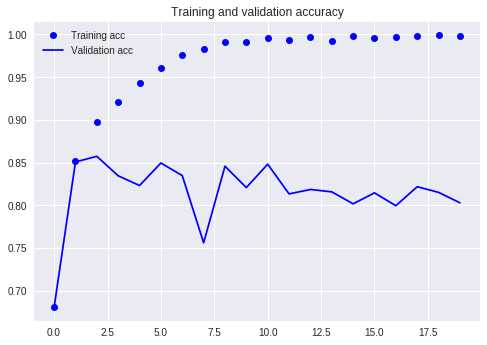

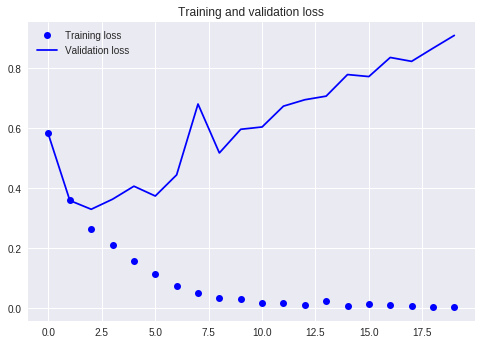

In [17]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

提醒一下，在第 3 章，处理这个数据集的第一个简单方法得到的测试精度是 88%。不幸的是，
与这个基准相比，这个小型循环网络的表现并不好（验证精度只有 85%）。问题的部分原因在于，
输入只考虑了前 500 个单词，而不是整个序列， 因此， RNN 获得的信息比前面的基准模型更少。
另一部分原因在于， SimpleRNN 不擅长处理长序列，比如文本。

其他类型的循环层的表现要好得多。我们来看几个更高级的循环层。

[...]

## Keras 中一个 LSTM 的具体例子

现在我们来看一个更实际的问题：使用 LSTM 层来创建一个模型，然后在 IMDB 数据上
训练模型。 这个网络与前面介绍的 SimpleRNN 网络类似。你只需指定
LSTM 层的输出维度，其他所有参数（有很多）都使用 Keras 默认值。 Keras 具有很好的默认值，
无须手动调参，模型通常也能正常运行。

In [18]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(10000, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

# n = 4 * ((x_dim + y_dim) * y_dim + y_dim)
# 8320 = 4*((32+32)*32+32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


In [0]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 87s 4ms/step - loss: 0.5027 - acc: 0.7550 - val_loss: 0.4240 - val_acc: 0.8146
Epoch 2/20
20000/20000 [==============================] - 85s 4ms/step - loss: 0.3005 - acc: 0.8810 - val_loss: 0.6332 - val_acc: 0.7598
Epoch 3/20
20000/20000 [==============================] - 87s 4ms/step - loss: 0.2397 - acc: 0.9102 - val_loss: 0.2905 - val_acc: 0.8874
Epoch 4/20
20000/20000 [==============================] - 86s 4ms/step - loss: 0.2071 - acc: 0.9235 - val_loss: 0.3094 - val_acc: 0.8906
Epoch 5/20
20000/20000 [==============================] - 87s 4ms/step - loss: 0.1835 - acc: 0.9331 - val_loss: 0.3784 - val_acc: 0.8696
Epoch 6/20
20000/20000 [==============================] - 86s 4ms/step - loss: 0.1633 - acc: 0.9419 - val_loss: 0.8285 - val_acc: 0.7670
Epoch 7/20
20000/20000 [==============================] - 87s 4ms/step - loss: 0.1452 - acc: 0.9479 - val_loss: 0.4028 - val_acc:

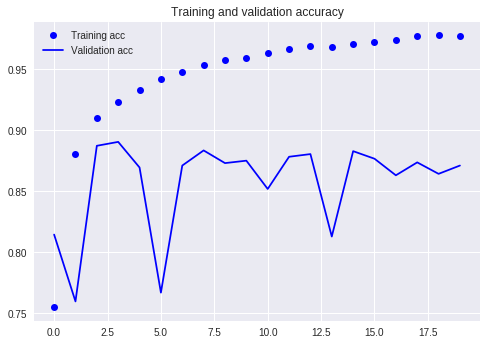

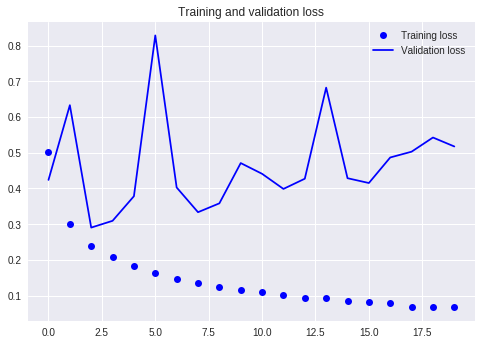

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

这一次，验证精度达到了 89%。还不错，肯定比 SimpleRNN 网络好多了，这主要是因为
LSTM 受梯度消失问题的影响要小得多。这个结果也比第 3 章的全连接网络略好，虽然使用的数据量比第 3 章要少。此处在 500 个时间步之后将序列截断，而在第 3 章是读取整个序列。

但对于一种计算量如此之大的方法而言，这个结果也说不上是突破性的。为什么 LSTM 不
能表现得更好？一个原因是你没有花力气来调节超参数，比如嵌入维度或 LSTM 输出维度。另
一个原因可能是缺少正则化。但说实话，主要原因在于，适用于评论分析全局的长期性结构（这
正是 LSTM 所擅长的），对情感分析问题帮助不大。对于这样的基本问题，观察每条评论中出现
了哪些词及其出现频率就可以很好地解决。这也正是第一个全连接方法的做法。但还有更加困
难的自然语言处理问题，特别是问答和机器翻译，这时 LSTM 的优势就明显了。